# Exploring and Visualizing Data Distributions

This tutorial demonstrates how to use Shapash to explore and visualize feature distributions in a dataset. By analyzing distributions, we gain a better understanding of the data, identify patterns, and spot potential issues such as outliers or imbalances.

We will use the Kaggle [Titanic dataset](https://www.kaggle.com/c/titanic/data)

In [1]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import train_test_split
from shapash.data.data_loader import data_loading
from category_encoders import OrdinalEncoder
from shapash import SmartExplainer
from shapash.plots.plot_correlations import plot_correlations
from shapash.plots.plot_univariate import plot_distribution
from shapash.plots.plot_evaluation_metrics import plot_confusion_matrix

## Load Titanic Dataset
We start by loading and preprocessing the Titanic dataset, which contains passenger information. The target variable is `Pclass`.

In [2]:
# Load dataset
titanic_df, titanic_dict = data_loading('titanic')

# Preprocessing
titanic_df.drop(columns=['Name'], inplace=True)
y_df = titanic_df[['Pclass']]
X_df = titanic_df.drop(columns=['Pclass'])

# Show sample data
titanic_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
PassengerId,,,,,,,,,
1,0,Third class,male,22.0,1,0,7.25,Southampton,Mr
2,1,First class,female,38.0,1,0,71.28,Cherbourg,Mrs
3,1,Third class,female,26.0,0,0,7.92,Southampton,Miss
4,1,First class,female,35.0,1,0,53.10,Southampton,Mrs
5,0,Third class,male,35.0,0,0,8.05,Southampton,Mr


## Visualizing Correlations in the Dataset

Understanding the relationships between features in a dataset is a crucial step in exploratory data analysis. Correlation matrices help identify how strongly pairs of variables are related. 

Using `plot_correlations`, we can generate a heatmap to visualize the correlation coefficients between all numerical features in the dataset. The heatmap uses a color gradient to represent the strength and direction of correlations:


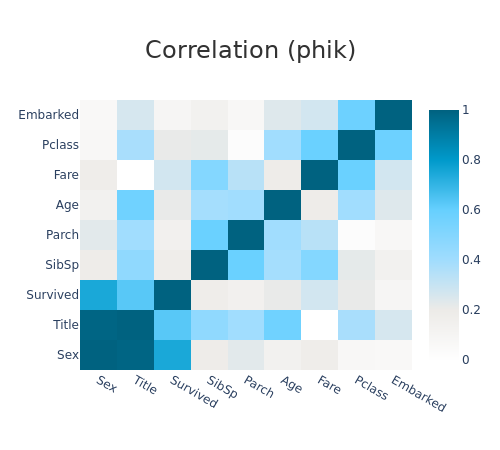

In [ ]:
plot_correlations(titanic_df, width=500, height=450, palette_name="blues")

## Explore Feature Distributions
Visualize the distributions of key features to better understand the dataset. We can do it before creating the model.

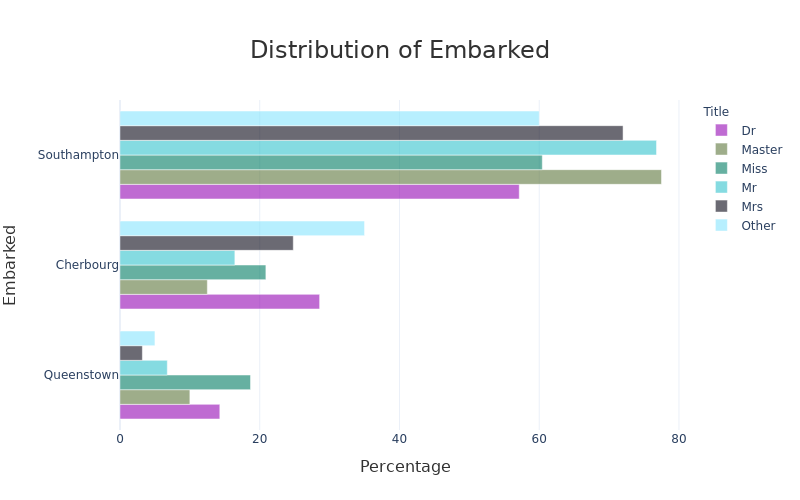

In [ ]:
plot_distribution(df_all=X_df, col='Embarked', hue='Title', height=500, nb_cat_max=7, nb_hue_max=5, width=800)

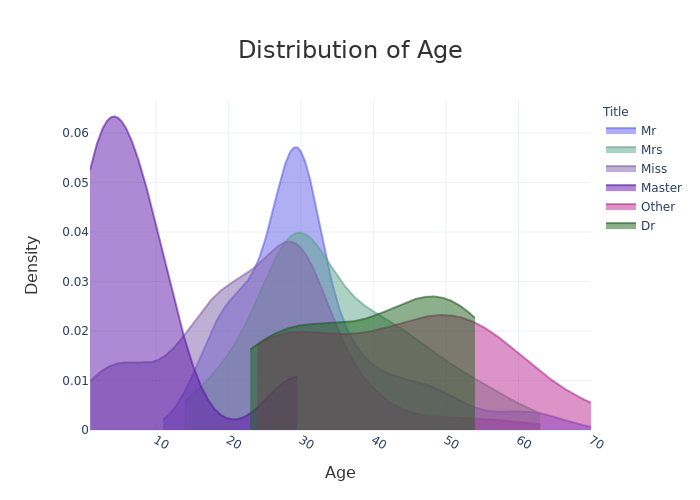

In [ ]:
plot_distribution(df_all=X_df, col='Age', hue='Title', nb_hue_max=5)

## Encode Categorical Features
Ordinal encoding is applied to transform categorical features into numeric format for model training.

In [6]:
# Identify categorical features
categorical_features = [col for col in X_df.columns if X_df[col].dtype == 'object']

# Apply encoding
encoder = OrdinalEncoder(cols=categorical_features, handle_unknown='ignore').fit(X_df)
encoder_target = OrdinalEncoder(cols=['Pclass'], handle_unknown='ignore').fit(y_df)

X_df = encoder.transform(X_df)
y_df = encoder_target.transform(y_df)

## Split Data and Train Model
We split the data into training and testing sets and train an ExtraTreesClassifier.

In [7]:
# Split data
Xtrain, Xtest, ytrain, ytest = train_test_split(X_df, y_df, train_size=0.75, random_state=7)

# Reset indices
Xtrain.reset_index(drop=True, inplace=True)
ytrain.reset_index(drop=True, inplace=True)
Xtest.reset_index(drop=True, inplace=True)
ytest.reset_index(drop=True, inplace=True)

# Train model
clf = ExtraTreesClassifier(n_estimators=200, random_state=7)
clf.fit(Xtrain, ytrain.iloc[:, 0])

ExtraTreesClassifier(n_estimators=200, random_state=7)

## Compile Explainability Model
We use SmartExplainer to create an explainability framework for analyzing model predictions.

In [8]:
# Mapping encoded labels to original labels
mappings = encoder_target.mapping[0]
encoded_to_original = {v: k for k, v in mappings['mapping'].items()}
encoded_to_original.pop(-2)  # Remove invalid mappings

# Initialize SmartExplainer
xpl = SmartExplainer(model=clf, preprocessing=encoder, features_dict=titanic_dict, label_dict=encoded_to_original)

# Compile explainability model
xpl.compile(x=Xtest, y_target=ytest.iloc[:, 0])

INFO: Shap explainer type - <shap.explainers._tree.TreeExplainer object at 0x7f0b4c996040>


## Visualization

We can conveniently display the previous plots for the test set and the confusion matrix using built-in functions.

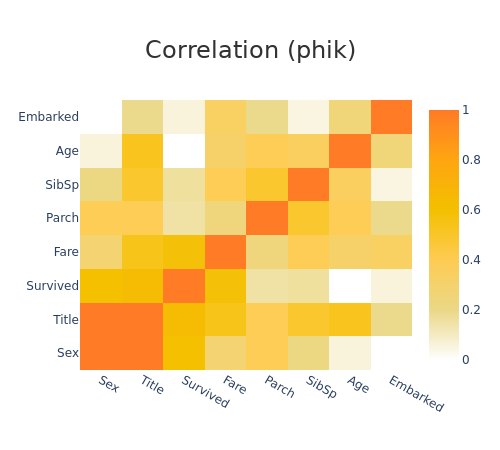

In [ ]:
xpl.plot.correlations_plot(width=500, height=450)

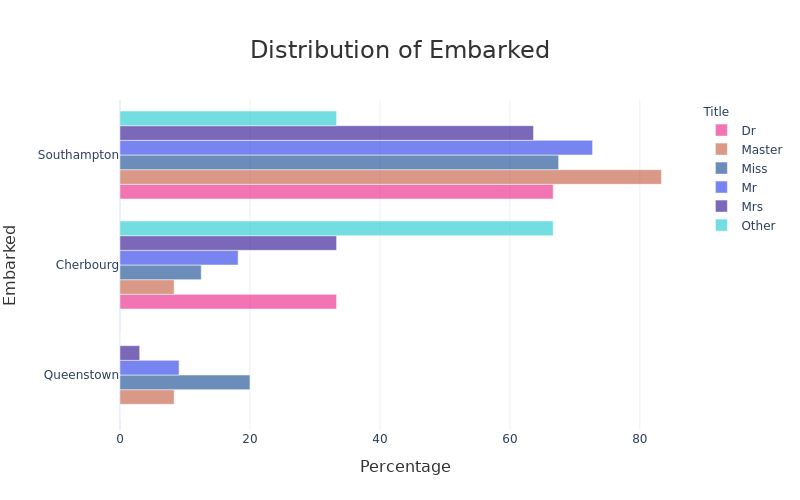

In [ ]:
# Feature distribution
xpl.plot.distribution_plot(col='Embarked', hue='Title', height=500, nb_cat_max=7, nb_hue_max=5, width=800)

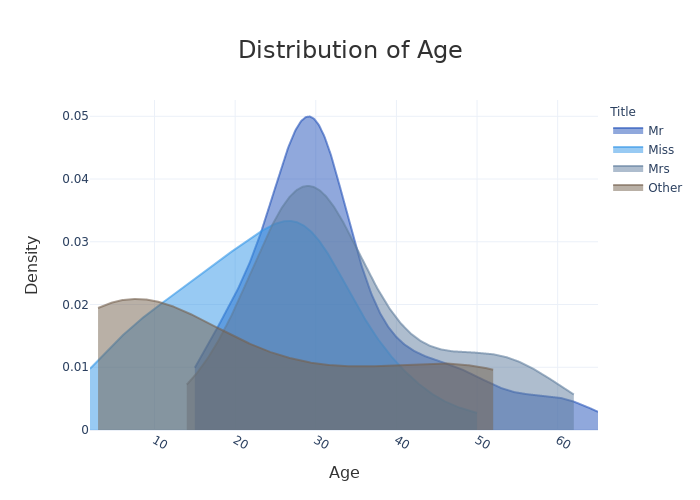

In [ ]:
xpl.plot.distribution_plot(col='Age', hue='Title', nb_hue_max=3)

### Visualizing the Confusion Matrix

The confusion matrix is a valuable tool to evaluate the performance of a classification model. It compares the actual labels with the predicted ones, highlighting where the model excels and where it makes errors.


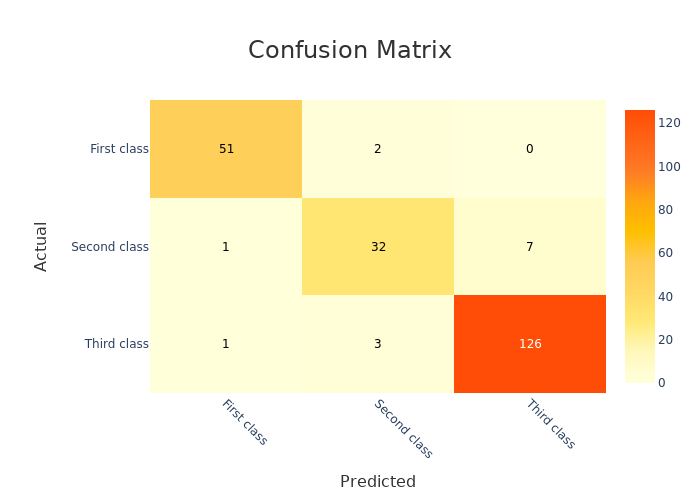

In [ ]:
# Confusion matrix
xpl.plot.confusion_matrix_plot()

Using `plot_confusion_matrix`, we can plot the confusion matrix and customize its appearance. For example, you can choose a specific color palette to enhance visualization or align it with your report or presentation style.

#### Customizing the Confusion Matrix Colors
- **`palette_name`**: Specify the color palette (e.g., "blues", "default").
- **`colors_dict`**: Optionally, provide a custom dictionary to define specific colors for elements of the matrix.

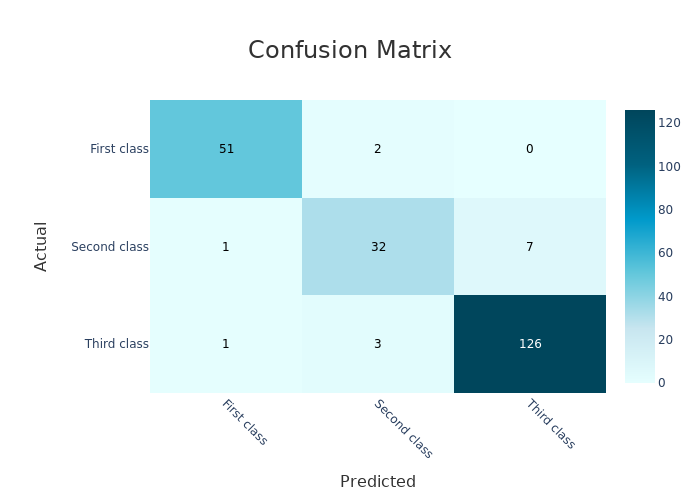

In [ ]:
# Confusion matrix
plot_confusion_matrix(
    y_true=xpl.y_target.iloc[:, 0].map(encoded_to_original),
    y_pred=xpl.y_pred.iloc[:, 0].map(encoded_to_original),
    palette_name="blues"
)